### 1-bit Identity Comparator
This notebook implements a 1-bit identity comparator with CBLB blocks.

#### Setting up the imports
External libraries + our own models and parameters

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import lib.models as models
from lib.parameters import *

#### Comparator model
Building our comparator model

In [29]:
def comparator_model(T, state, *params):
    # Read the state
    L_A, L_B, L_I1, L_I2, L_I3, L_I4, L_I5, L_I6, L_I7, a, b, I1, I2, I3, I4, I5, I6, I7 = state
    # Read the params
    delta_L, gamma_A, gamma_B, n_a, n_b, theta_A, theta_B, eta_a, eta_b, omega_a, omega_b, m_a, m_b, delta_a, delta_b, rho_a, rho_b = params

    ### 1. step NEG(NEG(A) v NEG(B))

    #  NEG(A)
    state_neg = L_I1, I1, a
    # Prepare params for neg
    params_neg = delta_L, gamma_A, n_b, theta_A, eta_a, omega_a, m_a, delta_a, rho_a
    dL_I1, dI1 = models.not_cell_wrapper(state_neg, params_neg)

    # NEG(B)
    state_neg = L_I2, I2, b
    # Prepare params for neg
    params_neg = delta_L, gamma_A, n_b, theta_A, eta_a, omega_a, m_a, delta_a, rho_a
    dL_I2, dI2 = models.not_cell_wrapper(state_neg, params_neg)

    # Inner part (OR)
    # Prepare state for or
    state_or = I1, I2, I3
    # Prepare params for or
    params_or = delta_L, gamma_A, n_b, theta_A, eta_a, omega_a, m_a, delta_a, rho_a
    dI3 = models.yes_yes_or(state_or, params_or)

    # Outer part (NEG)
    # Prepare state for neg
    state_neg = L_I4, I4, I3
    # Prepare params for neg
    params_neg = delta_L, gamma_A, n_b, theta_A, eta_a, omega_a, m_a, delta_a, rho_a
    dL_I4, dI4 = models.not_cell_wrapper(state_neg, params_neg)

    ### 2. step NEG(A v B)

    # Inner part (OR)
    # Prepare state for or
    state_or = a, b, I5
    # Prepare params for or
    params_or = delta_L, gamma_A, n_b, theta_A, eta_a, omega_a, m_a, delta_a, rho_a
    dI5 = models.yes_yes_or(state_or, params_or)

    # Outer part (NEG)
    # Prepare state for neg
    state_neg = L_I6, I6, I5
    # Prepare params for neg
    params_neg = delta_L, gamma_A, n_b, theta_A, eta_a, omega_a, m_a, delta_a, rho_a
    dL_I6, dI6 = models.not_cell_wrapper(state_neg, params_neg)

    ### 3. step (I2 v I4)

    # Inner part (OR)
    # Prepare state for or
    state_yes_yes_or = I4, I6, I7
    # Prepare params for or
    params_or = delta_L, gamma_A, n_b, theta_A, eta_a, omega_a, m_a, delta_a, rho_a
    dI7 = models.yes_yes_or(state_yes_yes_or, params_or)

    # Set changes of unused variables to 0
    dL_A, dL_B, dL_I3, dL_I5, dL_I7, dA, dB = 0, 0, 0, 0, 0, 0, 0

    # We are finished
    return np.array([dL_A, dL_B, dL_I1, dL_I2, dL_I3, dL_I4, dL_I5, dL_I6, dL_I7, dA, dB, dI1, dI2, dI3, dI4, dI5, dI6, dI7])

In [48]:
# We do not understand why this one does not work!!! - Almost certainly issue in not_not_or
def not_working_comparator_model(T, state, *params):
    # Read the state
    L_A, L_B, L_I1, L_I2, L_I3, L_I4, L_I5, a, b, I1, I2, I3, I4, I5 = state
    # Read the params
    delta_L, gamma_A, gamma_B, n_a, n_b, theta_A, theta_B, eta_a, eta_b, omega_a, omega_b, m_a, m_b, delta_a, delta_b, rho_a, rho_b = params

    ### 1. step NEG(NEG(A) v NEG(B))

    # Inner part (OR)
    # Prepare state for or
    state_or = L_I1, a, b, I1
    # Prepare params for or
    params_or = delta_L, gamma_A, n_b, theta_A, eta_a, omega_a, m_a, delta_a, rho_a
    dL_I1, dI1 = models.not_not_or(state_or, params_or)

    # Outer part (NEG)
    # Prepare state for neg
    state_neg = L_I2, I2, I1
    # Prepare params for neg
    params_neg = delta_L, gamma_A, n_b, theta_A, eta_a, omega_a, m_a, delta_a, rho_a
    dL_I2, dI2 = models.not_cell_wrapper(state_neg, params_neg)

    ### 2. step NEG(A v B)

    # Inner part (OR)
    # Prepare state for or
    state_or = a, b, I3
    # Prepare params for or
    params_or = delta_L, gamma_A, n_b, theta_A, eta_a, omega_a, m_a, delta_a, rho_a
    dI3 = models.yes_yes_or(state_or, params_or)

    # Outer part (NEG)
    # Prepare state for neg
    state_neg = L_I4, I4, I3
    # Prepare params for neg
    params_neg = delta_L, gamma_A, n_b, theta_A, eta_a, omega_a, m_a, delta_a, rho_a
    dL_I4, dI4 = models.not_cell_wrapper(state_neg, params_neg)

    ### 3. step (I2 v I4)

    # Inner part (OR)
    # Prepare state for or
    state_yes_yes_or = I2, I4, I5
    # Prepare params for or
    params_or = delta_L, gamma_A, n_b, theta_A, eta_a, omega_a, m_a, delta_a, rho_a
    dI5 = models.yes_yes_or(state_yes_yes_or, params_or)

    # Set changes of unused variables to 0
    dL_A, dL_B, dL_I3, dL_I5, dA, dB = 0, 0, 0, 0, 0, 0

    # We are finished
    return np.array([dL_A, dL_B, dL_I1, dL_I2, dL_I3, dL_I4, dL_I5, dA, dB, dI1, dI2, dI3, dI4, dI5])

### Parameters
Setting the parameters

In [30]:
params = [delta_L,
          gamma_A,
          gamma_A,
          n_a,
          n_a,
          theta_A,
          theta_A,
          eta_a,
          eta_a,
          omega_a,
          omega_a,
          m_a,
          m_a,
          delta_a,
          delta_a,
          0,
          0]


### Testing the model
Running the simulation + Plotting the results

Iteration:  A: 0  B: 0
Iteration:  A: 0  B: 1
Iteration:  A: 1  B: 0
Iteration:  A: 1  B: 1


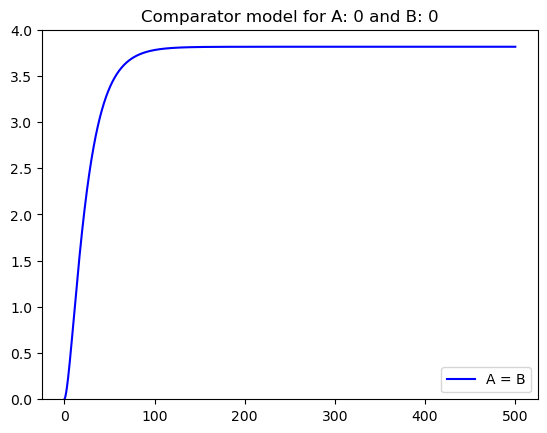

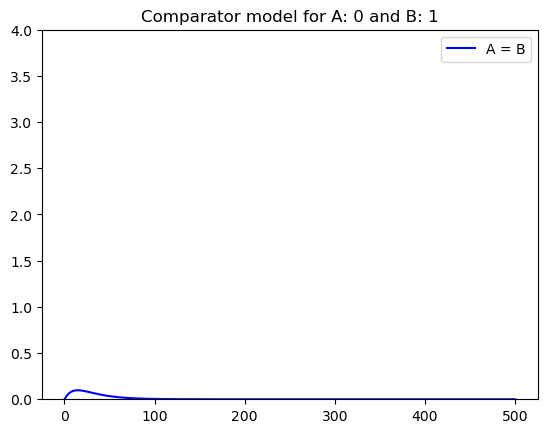

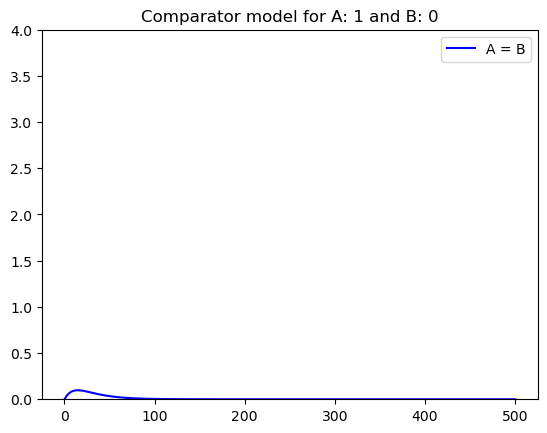

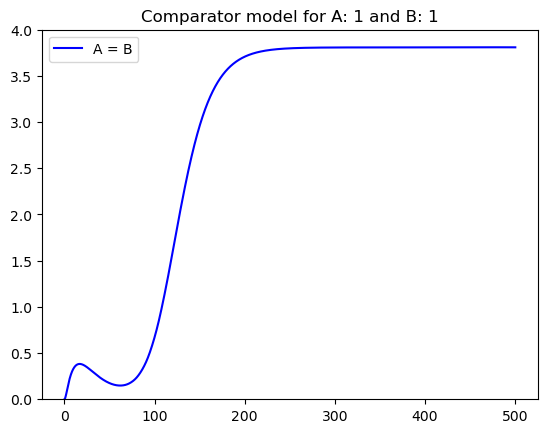

In [35]:
t_end = 500
N = t_end * 10
T = np.linspace(0, t_end, N)

for A in range(2):
    for B in range(2):
        print("Iteration: ", "A:", A, " B:", B)
        Y0 = np.zeros(18)
        Y0[9] = A
        Y0[10] = B
        sol = solve_ivp(comparator_model, [0, t_end], Y0, args=params, dense_output=True)
        z = sol.sol(T)
        # Value of A = B
        a_equal_b = z.T[:, 17]
        fig, ax = plt.subplots()
        #ax.plot(T, value_a, color="red", label="A")
        #ax.plot(T, value_b, color="blue", label="B")
        # ax.set_ylim(bottom=0, top=1)
        ax.set_ylim(bottom=0, top=4)
        ax.plot(T, a_equal_b, color="blue", label="A = B")
        ax.legend()
        title = "Comparator model for A: {a_bit} and B: {b_bit}".format(a_bit = A, b_bit = B)
        filename = "slike/1_bit_identity_comparator/png/comparator_A{a_bit}_B{b_bit}".format(a_bit = A, b_bit = B)
        ax.set_title(title)
        fig.savefig(filename)

Iteration:  A: 0  B: 0
Iteration:  A: 0  B: 1


e:\FAKS\2. stopnja\1. letnik\1. semester\NPMP\CBLB-Comparators\lib\models.py:23: RuntimeWarning: invalid value encountered in double_scalars
  dx_dt = gamma_x * (y ** n_y)/(1 + (theta_x*y)**n_y ) - (delta_x * x) - rho_x * x # rho ... increased degradation rate
e:\FAKS\2. stopnja\1. letnik\1. semester\NPMP\CBLB-Comparators\lib\models.py:10: RuntimeWarning: invalid value encountered in double_scalars
  f = gamma_L_X * (y ** n_y)/(1 + (theta_L_X*y)**n_y )


Iteration:  A: 1  B: 0
Iteration:  A: 1  B: 1


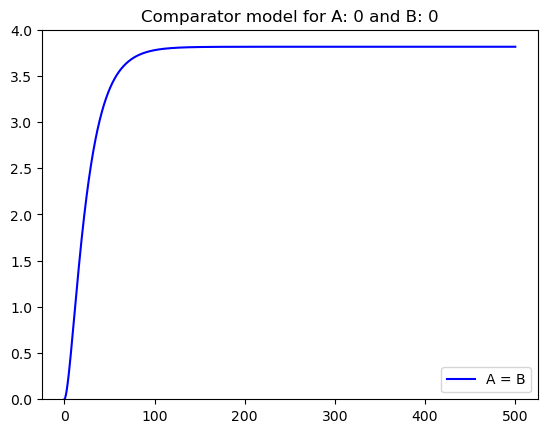

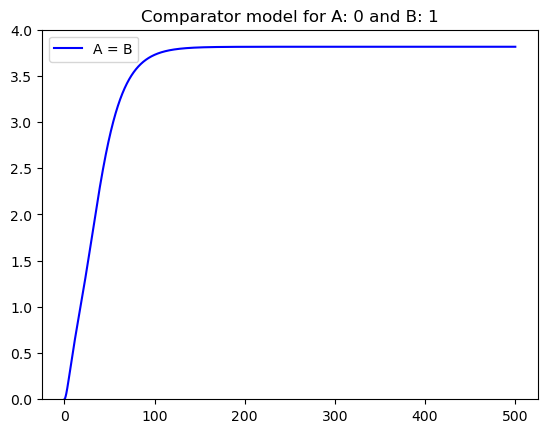

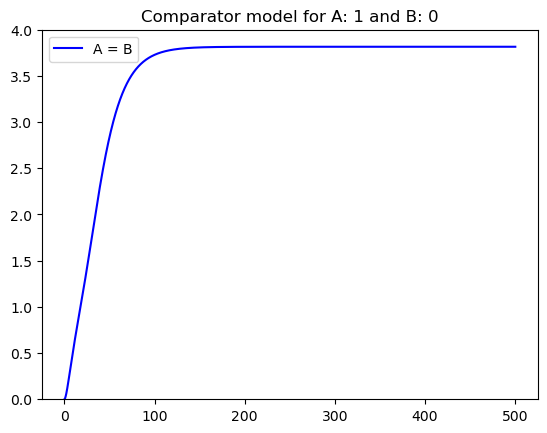

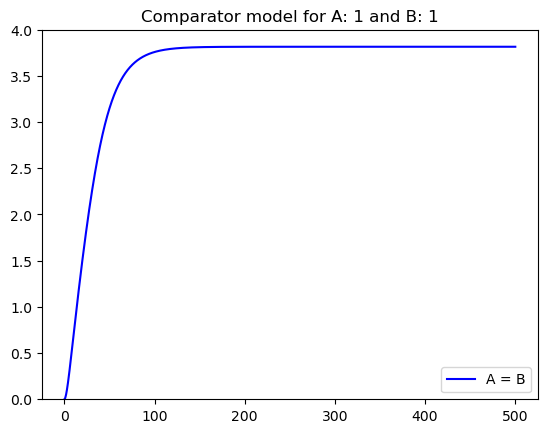

In [49]:
# Not working comparator model
t_end = 500
N = t_end * 10
T = np.linspace(0, t_end, N)

for A in range(2):
    for B in range(2):
        print("Iteration: ", "A:", A, " B:", B)
        Y0 = np.zeros(14)
        Y0[7] = A
        Y0[8] = B
        sol = solve_ivp(not_working_comparator_model, [0, t_end], Y0, args=params, dense_output=True)
        z = sol.sol(T)
        # Value of A = B
        a_equal_b = z.T[:, 13]
        fig, ax = plt.subplots()
        #ax.plot(T, value_a, color="red", label="A")
        #ax.plot(T, value_b, color="blue", label="B")
        # ax.set_ylim(bottom=0, top=1)
        ax.set_ylim(bottom=0, top=4)
        ax.plot(T, a_equal_b, color="blue", label="A = B")
        ax.legend()
        title = "Comparator model for A: {a_bit} and B: {b_bit}".format(a_bit = A, b_bit = B)
        filename = "slike/1_bit_identity_comparator/png/comparator_A{a_bit}_B{b_bit}".format(a_bit = A, b_bit = B)
        ax.set_title(title)
        fig.savefig(filename)